# Прикладная статистика и анализ данных
## Задание 2.11


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в latex/markdown и прислать `pdf` или же прислать фотку в правильной ориентации рукописного решения, где **все четко видно**.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание:**

* Задача 1 &mdash; 10 баллов;
* Задача 2 &mdash; 3 балла.

### Задача 1.

Повторите исследование из задачи 6 задания 2.7 (про интернет-магазин) для методов CUPED и CUPAC.

In [59]:
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [60]:
%%time
data = pd.read_excel('archive (3)/Online Retail.xlsx')

CPU times: total: 59 s
Wall time: 59 s


In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [157]:
data_april_may = data[data['InvoiceDate'].apply(lambda date: date.month == 4 or date.month == 5)]
data_april_may = data_april_may.dropna()
data_april_may

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161.0,United Kingdom
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161.0,United Kingdom
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161.0,United Kingdom
...,...,...,...,...,...,...,...,...
208730,555147,84707A,SILVER JEWELLED MIRROR TRINKET TRAY,2,2011-05-31 15:41:00,9.95,13505.0,Switzerland
208731,555147,84711A,SILVER OVAL SHAPE TRINKET BOX,2,2011-05-31 15:41:00,9.95,13505.0,Switzerland
208732,555147,84711B,PINK OVAL SHAPE TRINKET BOX,2,2011-05-31 15:41:00,9.95,13505.0,Switzerland
208733,555147,23101,SILVER STARS TABLE DECORATION,12,2011-05-31 15:41:00,0.83,13505.0,Switzerland


In [158]:
unique_id_april_may = pd.unique(data_april_may['CustomerID'])
len(unique_id_april_may)

1579

Посмотрим на распределение данных.

In [159]:
X = []
for cus in unique_id_april_may:
    X.append(data_april_may['Quantity'][data_april_may['CustomerID'] == cus].sum())
    
X = np.array(X)
X = X[X >= 0]
len(X)

1543

In [160]:
import statsmodels.api as sm

In [161]:
kde = sm.nonparametric.KDEUnivariate(X)
kde.fit()  # Estimate the densities

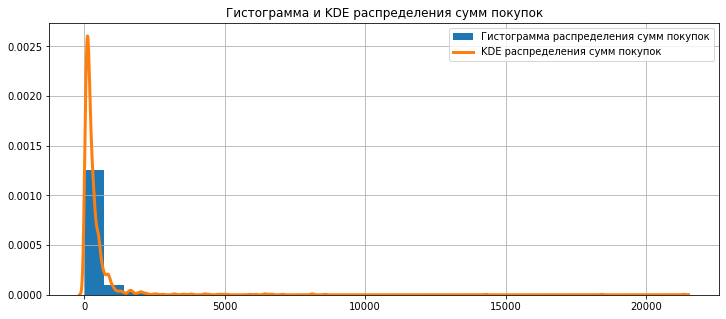

In [162]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.hist(X, label='Гистограмма распределения сумм покупок', density=True, bins=30)
ax.plot(kde.support, kde.density, lw=3, label="KDE распределения сумм покупок", zorder=10)
ax.legend(loc="best")
ax.grid(True, zorder=-5)
plt.title('Гистограмма и KDE распределения сумм покупок')
plt.show()

Видно, что распределение похоже на экспоненциальное, однако присутствуют сильные выбросы.

Возьмем в качестве предпериода все данные до апреля, а в качестве периода тестирования апрель-май. Также стоит отметить, что, вообще говоря, неправильно проводить AA-тест и AB-тест на одних и тех же данных (пусть и с добавлением шума), однако, так как это учебный пример, то сделаем так.

In [163]:
data_pre = data[data['InvoiceDate'].apply(lambda date: date.month == 2 or date.month == 3)]
data_pre

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom
...,...,...,...,...,...,...,...,...
142078,548548,22423,REGENCY CAKESTAND 3 TIER,1,2011-03-31 19:54:00,12.75,17781.0,United Kingdom
142079,548548,21361,LOVE LARGE WOOD LETTERS,7,2011-03-31 19:54:00,12.75,17781.0,United Kingdom
142080,548549,84763,ZINC FINISH 15CM PLANTER POTS,100,2011-03-31 19:55:00,1.06,16365.0,United Kingdom
142081,548549,22222,CAKE PLATE LOVEBIRD WHITE,1,2011-03-31 19:55:00,4.95,16365.0,United Kingdom


In [164]:
unique_id_pre = pd.unique(data_pre['CustomerID'])
len(unique_id_pre)

1474

In [165]:
unique_id = []

for u_id in unique_id_april_may:
    if u_id in unique_id_pre:
        unique_id.append(u_id)
        
len(unique_id)

776

In [166]:
data_april_may_grouped = data_april_may.groupby(['CustomerID', 'Country']).sum().reset_index()
data_april_may_grouped = data_april_may_grouped[data_april_may_grouped['Quantity'] >= 0]
data_april_may_grouped

,CustomerID,Country,Quantity,UnitPrice
0,12347.0,Iceland,483,62.29
1,12348.0,Finland,269,44.60
2,12353.0,Bahrain,20,24.30
3,12354.0,Spain,530,261.22
4,12355.0,Bahrain,240,54.65
...,...,...,...,...
1573,18260.0,United Kingdom,455,186.39
1574,18263.0,United Kingdom,328,15.77
1576,18272.0,United Kingdom,782,113.50
1577,18283.0,United Kingdom,149,158.06


In [167]:
pd.unique(data_april_may_grouped['Country'])

array(['Iceland', 'Finland', 'Bahrain', 'Spain', 'Portugal', 'Austria',
       'Belgium', 'Unspecified', 'Denmark', 'Australia', 'France',
       'Germany', 'Switzerland', 'Sweden', 'Poland', 'Italy', 'Greece',
       'USA', 'Singapore', 'United Kingdom', 'Japan', 'Brazil',
       'Netherlands', 'EIRE', 'Channel Islands', 'European Community',
       'Canada'], dtype=object)

In [168]:
data_pre_grouped = data_pre.groupby('CustomerID').sum().reset_index()
data_pre_grouped

,CustomerID,Quantity,UnitPrice
0,12350.0,197,65.30
1,12352.0,188,1900.07
2,12359.0,465,809.98
3,12361.0,91,33.35
4,12362.0,227,77.10
...,...,...,...
1468,18260.0,356,98.60
1469,18270.0,41,21.15
1470,18273.0,20,2.55
1471,18280.0,45,47.65


**1.**
На искусственных данных мы уже проверили наш тест, теперь пора проверить на реальных. На данных за апрель и май проведите множество случайных AA-тестов для определения реального уровня значимости, выбирая случайных пользователей в каждую из групп. Использовать нужно группы одинакого размера, конечно же, они не должны пересекаться. Для каждого пользователя рассматриваем общую сумму его покупок за два месяца.

Для начала напишем вспомогательные функции.

In [204]:
def make_groups_and_periods(control_id, test_id, sample_size, eps, scale=10, 
                            data_pre=data_pre, data_april_may=data_april_may):
    '''Делает данные для предпериода, АА- и АВ-теста для контрольной и тестовой групп'''
    x_pre = np.zeros_like(control_id)
    y_pre = np.zeros_like(test_id)
    x_aa = np.zeros_like(control_id)
    x_ab = np.zeros_like(control_id)
    y_aa = np.zeros_like(test_id)
    y_ab = np.zeros_like(test_id)

    i = 0
    for id_x, id_y in zip(control_id, test_id):
        x_pre[i] = data_pre['Quantity'][data_pre['CustomerID'] == id_x].sum()
        x_aa[i] = data_april_may['Quantity'][data_april_may['CustomerID'] == id_x].sum()
        x_ab[i] = data_april_may['Quantity'][data_april_may['CustomerID'] == id_x].sum()
        y_pre[i] = data_pre['Quantity'][data_pre['CustomerID'] == id_y].sum()
        y_aa[i] = data_april_may['Quantity'][data_april_may['CustomerID'] == id_y].sum()
        y_ab[i] = data_april_may['Quantity'][data_april_may['CustomerID'] == id_y].sum()

        i += 1

    x_ab += sps.norm(scale=10).rvs(len(x_ab))
    y_ab += sps.norm(scale=10).rvs(len(y_ab)) + eps
    
    return x_pre, x_aa, x_ab, y_pre, y_aa, y_ab

In [205]:
def find_unique_id(data_pre=data_pre, data_april_may=data_april_may):
    '''Находит совпадающие индексы покупателей у двух фреймов'''
    unique_id_pre = pd.unique(data_pre['CustomerID'])
    unique_id_april_may = pd.unique(data_april_may['CustomerID'])
    
    unique_id = []

    for u_id in unique_id_april_may:
        if u_id in unique_id_pre:
            unique_id.append(u_id)
            
    return unique_id 

In [206]:
def make_grouped_data(control_test_id, data_pre=data_pre, data_april_may=data_april_may):
    '''Группирует данные по индексу покупателя и стране и выделяет только нужных покупателей'''
    new_data_april_may = data_april_may[data_april_may['CustomerID'].isin(control_test_id)].dropna()
    data_april_may_grouped = new_data_april_may.groupby(['CustomerID', 'Country']).sum().reset_index()
    data_april_may_target = data_april_may_grouped['Quantity']
    data_april_may_grouped = pd.get_dummies(data_april_may_grouped, columns=['Country'], drop_first=True)
    new_data_pre = data_april_may[data_april_may['CustomerID'].isin(control_test_id)].dropna()
    data_pre_grouped = new_data_pre.groupby(['CustomerID', 'Country']).sum().reset_index()
    data_pre_target = data_pre_grouped['Quantity']
    data_pre_grouped = pd.get_dummies(data_pre_grouped, columns=['Country'], drop_first=True)
    return data_pre_grouped, data_pre_target, data_april_may_grouped, data_april_may_target

Фактически, CUPAC &mdash; это частный случай CUPED, поэтому в качестве признаков ML-модели при предикте можно брать те, на которые не оказывает влияние изменение таргета. Так как в учебных целях мы просто добавляем к таргету число и нормальную случайную величину, то на признаки изменение таргета не действует, поэтому мы можем использовать признаки, на тестовом периоде для предсказания на них таргета в методе CUPAC. Также стоит отметить, что, конечно, в реальной задаче не стоит брать все признаки в качестве признаков предсказывающей модели для CUPAC.

In [264]:
def AA_or_AB_test(n_iter=2000, sample_size=300, eps=20, scale=10, data_pre=data_pre, data_april_may=data_april_may, 
            method=None, alpha=0.05, AB=False, model=RandomForestRegressor()):
    '''Делает АА- или АВ-тест. Возвращает количество отвержений и массив p-value'''
    n_errors = 0
    pval_arr = []
    unique_id = find_unique_id(data_pre, data_april_may)
    for _ in tqdm(range(n_iter)):
        control_test_id = np.random.choice(unique_id, replace=False, size=(2 * sample_size))
        control_id = control_test_id[:sample_size]
        test_id = control_test_id[sample_size:]
        x_pre, x_aa, x_ab, y_pre, y_aa, y_ab = make_groups_and_periods(control_id=control_id, test_id=test_id, 
                                                                       sample_size=sample_size, eps=eps, scale=scale, 
                                                                       data_pre=data_pre, data_april_may=data_april_may)
        x_exp = x_ab if AB else x_aa
        y_exp = y_ab if AB else y_aa
        if method is None:
            x_modified = x_exp
            y_modified = y_exp
        elif method == 'CUPED':
            theta = (np.cov(x_pre, x_exp)[0,1] + np.cov(y_pre, y_exp)[0,1]) / (x_pre.var() + y_pre.var())
            x_modified = x_exp - theta * x_pre
            y_modified = y_exp - theta * y_pre
        else:
            data_pre_grouped, data_pre_target, data_april_may_grouped, data_april_may_target = \
                        make_grouped_data(control_test_id, data_pre, data_april_may)
            model.fit(data_pre_grouped.drop(['Quantity', 'CustomerID'], axis=1), data_pre_target)
            pred = model.predict(data_april_may_grouped.drop(['Quantity', 'CustomerID'], axis=1))
            x_pre_modified = np.zeros_like(control_id)
            y_pre_modified = np.zeros_like(test_id)
            i = 0
            for id_x, id_y in zip(control_id, test_id):
                x_pre_modified[i] = pred[(data_april_may_grouped[data_april_may_grouped['CustomerID'] == id_x]).index[0]]
                y_pre_modified[i] = pred[(data_april_may_grouped[data_april_may_grouped['CustomerID'] == id_y]).index[0]]
                i += 1
            theta = (np.cov(x_pre_modified, x_exp)[0,1] + np.cov(y_pre_modified, y_exp)[0,1]) / \
                                (x_pre_modified.var() + y_pre_modified.var())
            x_modified = x_exp - theta * x_pre_modified
            y_modified = y_exp - theta * y_pre_modified
            
        pval = sps.ttest_ind(x_modified, y_modified)[1]
        pval_arr.append(pval)
        n_errors += (pval <= alpha)
        
    return n_errors, pval_arr

* AA-тест для необработанных данных.

In [220]:
n_iter = 2000
alpha = 0.05

n_errors, pval_arr = AA_or_AB_test(n_iter=n_iter, alpha=alpha)
print('{:.4f} +/- {:.4f}'.format(n_errors / n_iter, 2 * np.sqrt(alpha / n_iter)))

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0465 +/- 0.0100


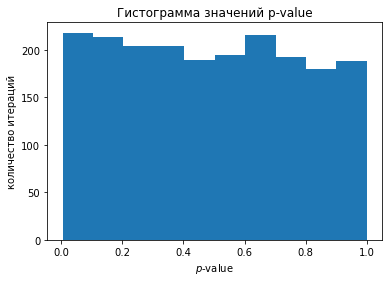

In [221]:
plt.hist(pval_arr)
plt.xlabel('$p$-value')
plt.ylabel('количество итераций')
plt.title("Гистограмма значений p-value")
plt.show()

* AA-тест для данных, обработанных с помощью CUPED.

In [222]:
n_errors_cuped, pval_arr_cuped = AA_or_AB_test(n_iter=n_iter, alpha=alpha, method='CUPED')
print('{:.4f} +/- {:.4f}'.format(n_errors_cuped / n_iter, 2 * np.sqrt(alpha / n_iter)))

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0465 +/- 0.0100


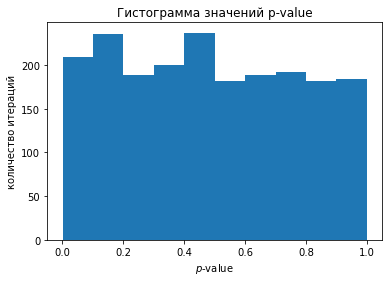

In [224]:
plt.hist(pval_arr_cuped)
plt.xlabel('$p$-value')
plt.ylabel('количество итераций')
plt.title("Гистограмма значений p-value")
plt.show()

* AA-тест для данных, обработанных с помощью CUPAC.

In [225]:
n_errors_cupac, pval_arr_cupac = AA_or_AB_test(n_iter=n_iter, alpha=alpha, method='CUPAC')
print('{:.4f} +/- {:.4f}'.format(n_errors_cupac / n_iter, 2 * np.sqrt(alpha / n_iter)))

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0485 +/- 0.0100


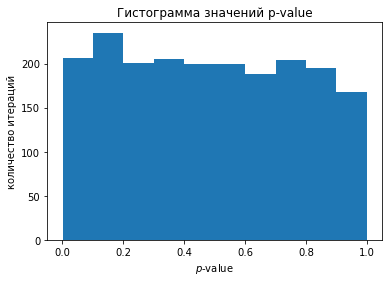

In [226]:
plt.hist(pval_arr_cupac)
plt.xlabel('$p$-value')
plt.ylabel('количество итераций')
plt.title("Гистограмма значений p-value")
plt.show()

**2.** С помощью проведения AB-теста по историческим данных выясните, какова мощность теста для разных значений эффекта. Схема проведения аналогична предыдущему пункту, но к тестовой группе нужно добавить положительное смещение.

При добавлении искусственного смещения рекомендуется также добавлять небольшой шум для каждого пользователя. Поясните, для этого это может быть полезно.

Рассмотрим эффект разного масштаба: 20, 50, 100, 200, 500.

* $\varepsilon = 20.$

In [231]:
eps = 20

Посмотрим размер эффекта, который мы добавили:

In [242]:
sample_size = 300

control_test_id = np.random.choice(unique_id, replace=False, size=(2 * sample_size))
control_id = control_test_id[:sample_size]
test_id = control_test_id[sample_size:]

x_pre, x_aa, x_ab, y_pre, y_aa, y_ab = make_groups_and_periods(control_id, test_id, sample_size, eps)

In [243]:
eps / np.mean(y_ab)

0.0357840745024042

Посмотрим на дисперсию статистики.

In [244]:
tstat_var = x_ab.var() / len(x_ab) + y_ab.var() / len(y_ab)
tstat_var

16486.37891036951

Теперь на дисперсию статистики после CUPED.

In [235]:
theta = (np.cov(x_pre, x_ab)[0,1] + np.cov(y_pre, y_ab)[0,1]) / (x_pre.var() + y_pre.var())
x_modified = x_ab - theta * x_pre
y_modified = y_ab - theta * y_pre
tstat_var = x_modified.var() / len(x_modified) + y_modified.var() / len(y_modified)
tstat_var

5328.700573287723

Теперь на дисперсию статистики после CUPAC.

In [247]:
data_pre_grouped, data_pre_target, data_april_may_grouped, data_april_may_target = \
                        make_grouped_data(control_test_id, data_pre, data_april_may)
model = RandomForestRegressor()
model.fit(data_pre_grouped.drop(['Quantity', 'CustomerID'], axis=1), data_pre_target)
pred = model.predict(data_april_may_grouped.drop(['Quantity', 'CustomerID'], axis=1))
x_pre_modified = np.zeros_like(control_id)
y_pre_modified = np.zeros_like(test_id)
i = 0
for id_x, id_y in zip(control_id, test_id):
    x_pre_modified[i] = pred[(data_april_may_grouped[data_april_may_grouped['CustomerID'] == id_x]).index[0]]
    y_pre_modified[i] = pred[(data_april_may_grouped[data_april_may_grouped['CustomerID'] == id_y]).index[0]]
    i += 1
theta = (np.cov(x_pre_modified, x_ab)[0,1] + np.cov(y_pre_modified, y_ab)[0,1]) / \
                    (x_pre_modified.var() + y_pre_modified.var())
x_modified = x_ab - theta * x_pre_modified
y_modified = y_ab - theta * y_pre_modified
tstat_var = x_modified.var() / len(x_modified) + y_modified.var() / len(y_modified)
tstat_var

1650.7139957735055

А теперь давайте уже протестируем наши методы.

* AB-тест для необработанных данных.

In [250]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors, pval_arr = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps)
print('{:.4f} +/- {:.4f}'.format(n_errors / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0545 +/- 0.0100


* AB-тест для данных, обработанных с помощью CUPED.

In [257]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cuped, pval_arr_cuped = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPED')
print('{:.4f} +/- {:.4f}'.format(n_errors_cuped / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0510 +/- 0.0100


In [254]:
pval_arr_cuped

[0.18519091280885455,
 0.3331500592747316,
 0.549581644502296,
 0.4034569711644882,
 0.8975909765651569,
 0.9976305789184179,
 0.25709449084890246,
 0.7875179829880875,
 0.5274077332479661,
 0.22434358000785878,
 0.8495544490858675,
 0.9450186303732933,
 0.4714241635298657,
 0.1690547230202269,
 0.20609264234095667,
 0.282029070574245,
 0.407090433863343,
 0.6675125220760282,
 0.5663014397878046,
 0.896079669509897,
 0.3260817026259498,
 0.3658434948692726,
 0.22730840062562613,
 0.9110935930646917,
 0.9914068604813902,
 0.7428132341988727,
 0.8767623852121934,
 0.7567982856890532,
 0.3223644076371701,
 0.27474827676208513,
 0.9681289694034676,
 0.6997109852839734,
 0.7816306079663213,
 0.4349288201806063,
 0.547475438819994,
 0.421691522653573,
 0.5512007984323808,
 0.16514900247035144,
 0.41341548668590833,
 0.8426400556657209,
 0.1377784783479579,
 0.5256647142363884,
 0.1108311445620618,
 0.9889955248447714,
 0.496056987478786,
 0.09999891743909979,
 0.573586828501778,
 0.633494244

* AB-тест для данных, обработанных с помощью CUPAC.

In [274]:
eps = 20
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cupac, pval_arr_cupac = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPAC')
print('{:.4f} +/- {:.4f}'.format(n_errors_cupac / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0805 +/- 0.0100


$\varepsilon = 50.$

In [258]:
eps = 50

Посмотрим размер эффекта, который мы добавили:

In [259]:
sample_size = 300

control_test_id = np.random.choice(unique_id, replace=False, size=(2 * sample_size))
control_id = control_test_id[:sample_size]
test_id = control_test_id[sample_size:]

x_pre, x_aa, x_ab, y_pre, y_aa, y_ab = make_groups_and_periods(control_id, test_id, sample_size, eps)

In [260]:
eps / np.mean(y_ab)

0.08512295637503801

* AB-тест для необработанных данных.

In [270]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors, pval_arr = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps)
print('{:.4f} +/- {:.4f}'.format(n_errors / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0725 +/- 0.0100


* AB-тест для данных, обработанных с помощью CUPED.

In [275]:
eps = 50
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cuped, pval_arr_cuped = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPED')
print('{:.4f} +/- {:.4f}'.format(n_errors_cuped / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

0.1160 +/- 0.0100


* AB-тест для данных, обработанных с помощью CUPAC.

In [276]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cupac, pval_arr_cupac = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPAC')
print('{:.4f} +/- {:.4f}'.format(n_errors_cupac / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

0.2690 +/- 0.0100


$\varepsilon = 200.$

In [277]:
eps = 200

Посмотрим размер эффекта, который мы добавили:

In [278]:
sample_size = 300

control_test_id = np.random.choice(unique_id, replace=False, size=(2 * sample_size))
control_id = control_test_id[:sample_size]
test_id = control_test_id[sample_size:]

x_pre, x_aa, x_ab, y_pre, y_aa, y_ab = make_groups_and_periods(control_id, test_id, sample_size, eps)

In [279]:
eps / np.mean(y_ab)

0.22488913259915172

* AB-тест для необработанных данных.

In [280]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors, pval_arr = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps)
print('{:.4f} +/- {:.4f}'.format(n_errors / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4055 +/- 0.0100


* AB-тест для данных, обработанных с помощью CUPED.

In [281]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cuped, pval_arr_cuped = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPED')
print('{:.4f} +/- {:.4f}'.format(n_errors_cuped / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

0.8065 +/- 0.0100


* AB-тест для данных, обработанных с помощью CUPAC.

In [282]:
n_iter = 2000
alpha = 0.05

print(f'размер эффекта: {eps}')
n_errors_cupac, pval_arr_cupac = AA_or_AB_test(n_iter=n_iter, alpha=alpha, AB=True, eps=eps, method='CUPAC')
print('{:.4f} +/- {:.4f}'.format(n_errors_cupac / n_iter, 2 * np.sqrt(alpha / n_iter)))

размер эффекта: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

0.9990 +/- 0.0100


**Вывод:** 
* касаемо АА-теста: все критерии работают на заданном уровне значимости, гистограмма p-value тоже похожа на равномерную, значит, все хорошо;
* касаемо AB-теста: CUPED уменьшил дисперсию где-то в 3 раза, а CUPAC &mdash; аж в 10 раз. За счет этого при маленьком эффекте (20, около 4%) обычный t-test и t-test с CUPED почти ничего не отвергали, а t-test с CUPAC уже начал отвергать с частотой в 8%. При эффекте 50 (около 9%) обычный t-test отвергал слабо: около 7%, t-test с CUPED немного получше: около 11%, а с CUPAC &mdash; уже почти 27%. При эффекте 200 (около 22-23%) обычный t-test отвергал с частотой примерно 40%, t-test с CUPED &mdash; с частотой около 80% (что уже на примерно том уровне, на котором мы хотим видеть мощность), а мощность test с CUPAC оказалась почти уже 100% (отличается меньше погрешности). Исходя из рассчитанных дисперсий, стоило ожидать полученные результаты. Также стоит отметить, что предсказания модели с CUPAC являются отличной ковариатой и значительно уменьшают дисперсию, что позволяет в разы увеличить мощность критериев.

### Задача 2.

Пусть в общей совокупности данных имеется $K$ страт, причем вес страты $k \in \{1, ..., K\}$ равен $w_k$, где $w_1+...+w_K=1$. Пусть также выборка размера $n$ выбрана случайно, то есть вероятность выбрать элемент из страты $k$ равна $w_k$.

Посчитайте $\mathsf{E}_r \frac{1}{n_k}$ с точностью до $o(1/n^2)$, где $n_k$ &mdash; количество элементов выборки из страты $k$.

*Указание.* Разложите по Тейлору функцию $f(x)=1/x$ в точке $x_0\not=0$.